In [1]:
import os, sys

module_path = os.path.abspath(os.path.join("../.."))
sys.path.append(module_path)

## Load datasets

In [2]:
from SLTDataset import SLTDataset


# DATASETS = ["LSAT", "RWTH_PHOENIX_2014T", "GSL"]
DATASETS = ["GSL"]
DATA_DIR = "/mnt/disk3Tb/slt-datasets/"
INPUT_MODE = "pose"
OUTPUT_MODE = "gloss"


datasets: dict[str, SLTDataset] = {}
for dataset in DATASETS:
    datasets[dataset] = SLTDataset(
        data_dir=DATA_DIR + dataset,
        split="train",
        input_mode=INPUT_MODE,
        output_mode=OUTPUT_MODE,
    )

Loaded metadata for dataset: The Greek Sign Language (GSL) Dataset
Loaded train annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 8821/8821 [00:00<00:00, 272308.09it/s]

Dataset loaded correctly



In [3]:
import pandas as pd

from WordLevelTokenizer import WordLevelTokenizer


def get_tokenizer(dataset: SLTDataset) -> WordLevelTokenizer:
    tokenizer = WordLevelTokenizer()
    tokenizer.fit(dataset.annotations["text"].tolist())
    return tokenizer


samples: list[tuple[str, str, float, list[int]]] = []
tokenizers = {name: get_tokenizer(dataset) for name, dataset in datasets.items()}

for name, dataset in datasets.items():
    print(f"Processing dataset {name}")
    for i in range(len(dataset)):
        pose, text = dataset.get_item_raw(i)
        token_ids = tokenizers[name].encode(text)
        samples.append((name, text, len(pose), token_ids))
df = pd.DataFrame(samples, columns=["dataset", "text", "pose_length", "token_ids"])
df["token_length"] = df["token_ids"].apply(len)

Processing dataset GSL


In [4]:
df.head()

,dataset,text,pose_length,token_ids,token_length
0,GSL,ΓΕΙΑ ΕΓΩ(1) ΜΠΟΡΩ ΒΟΗΘΕΙΑ,96,"[2, 1, 1, 1, 1, 3]",6
1,GSL,ΕΓΩ(1) ΘΕΛΩ ΠΑΡΑΠΟΝΟ ΚΑΤΑΓΓΕΛΙΑ,93,"[2, 1, 1, 1, 1, 3]",6
2,GSL,ΠΡΟΒΛΗΜΑ ΤΙ;,44,"[2, 1, 1, 3]",4
3,GSL,ΩΡΑ ΓΙΑ ΗΣΥΧΙΑ ΑΚΟΥΩ ΦΑΣΑΡΙΑ,139,"[2, 1, 1, 1, 1, 1, 3]",7
4,GSL,ΠΟΙΟΣ; ΕΝΟΧΛΩ_ΕΣΕΝΑ,48,"[2, 1, 1, 3]",4


In [5]:
df.groupby("dataset").describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

dataset                     GSL
pose_length  count  8821.000000
             mean     99.978687
             std      78.051631
             min       6.000000
             10%      17.000000
             25%      39.000000
             50%      88.000000
             75%     135.000000
             90%     192.000000
             95%     252.000000
             99%     349.800000
             max     615.000000
token_length count  8821.000000
             mean      6.004081
             std       2.427868
             min       3.000000
             10%       3.000000
             25%       4.000000
             50%       6.000000
             75%       7.000000
             90%       9.000000
             95%      10.000000
             99%      13.000000
             max      20.000000

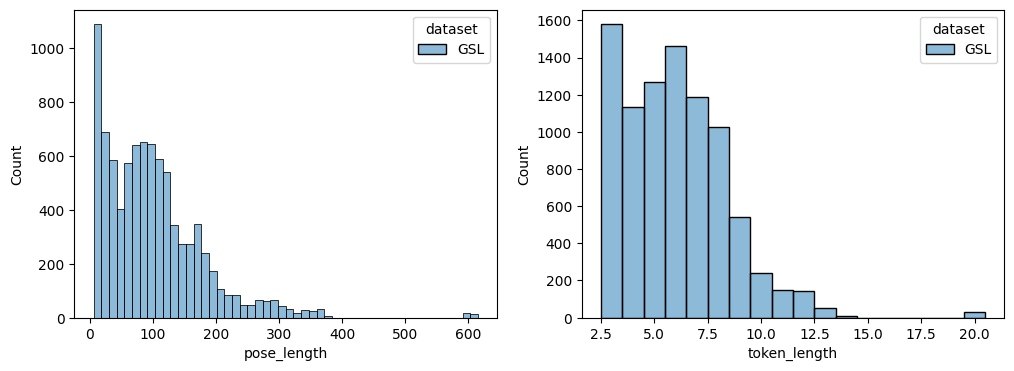

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=df, x="pose_length", hue="dataset", bins=50, ax=axs[0])
sns.histplot(
    data=df, x="token_length", hue="dataset", bins=50, ax=axs[1], discrete=True
)
plt.show()

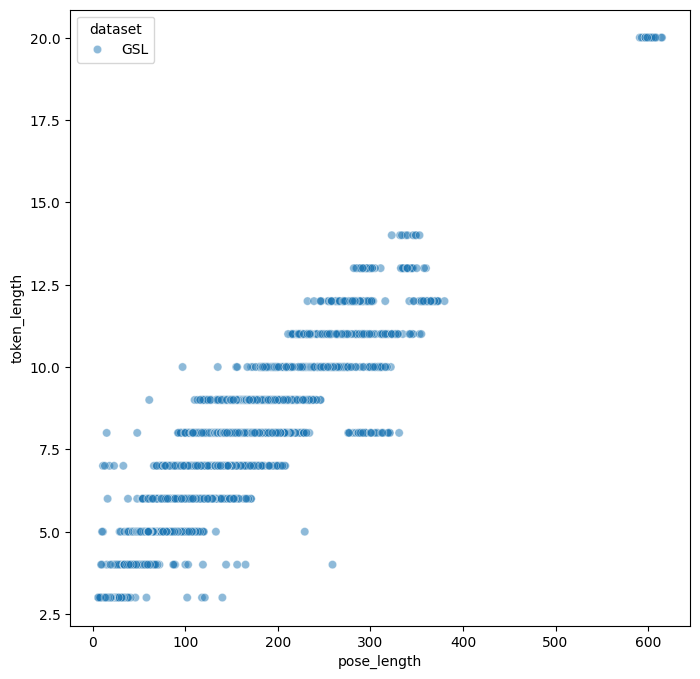

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(
    data=df, x="pose_length", y="token_length", hue="dataset", alpha=0.5, ax=ax
)
plt.show()

## Word frequency analysis

Percentage of different sentences over the whole dataset

In [9]:
100 * df.groupby("dataset")["text"].nunique() / df.groupby("dataset")["text"].count()

dataset
GSL    5.362204
Name: text, dtype: float64

In [10]:
full_texts = df.groupby("dataset").agg({"token_ids": "sum"})
full_texts["token_ids"] = full_texts["token_ids"].apply(
    lambda tokens: list(filter(lambda token: token != 2 and token != 3, tokens))
)
full_texts["token_ids"].apply(set).apply(len)

dataset
GSL    11
Name: token_ids, dtype: int64

In [11]:
full_texts_dfs = {
    dataset: pd.DataFrame(
        {"token": full_texts.loc[dataset, "token_ids"]},
    )
    for dataset in DATASETS
}
token_freqs = {}
for dataset in DATASETS:
    frequency_counts = (
        full_texts_dfs[dataset].value_counts().value_counts().sort_index()
    )
    token_freqs[dataset] = 100 * frequency_counts / frequency_counts.sum()

token_freqs_df = pd.DataFrame(token_freqs)
token_freqs_df.head()

,GSL
count,
30,36.363636
31,9.090909
59,9.090909
60,27.272727
119,9.090909


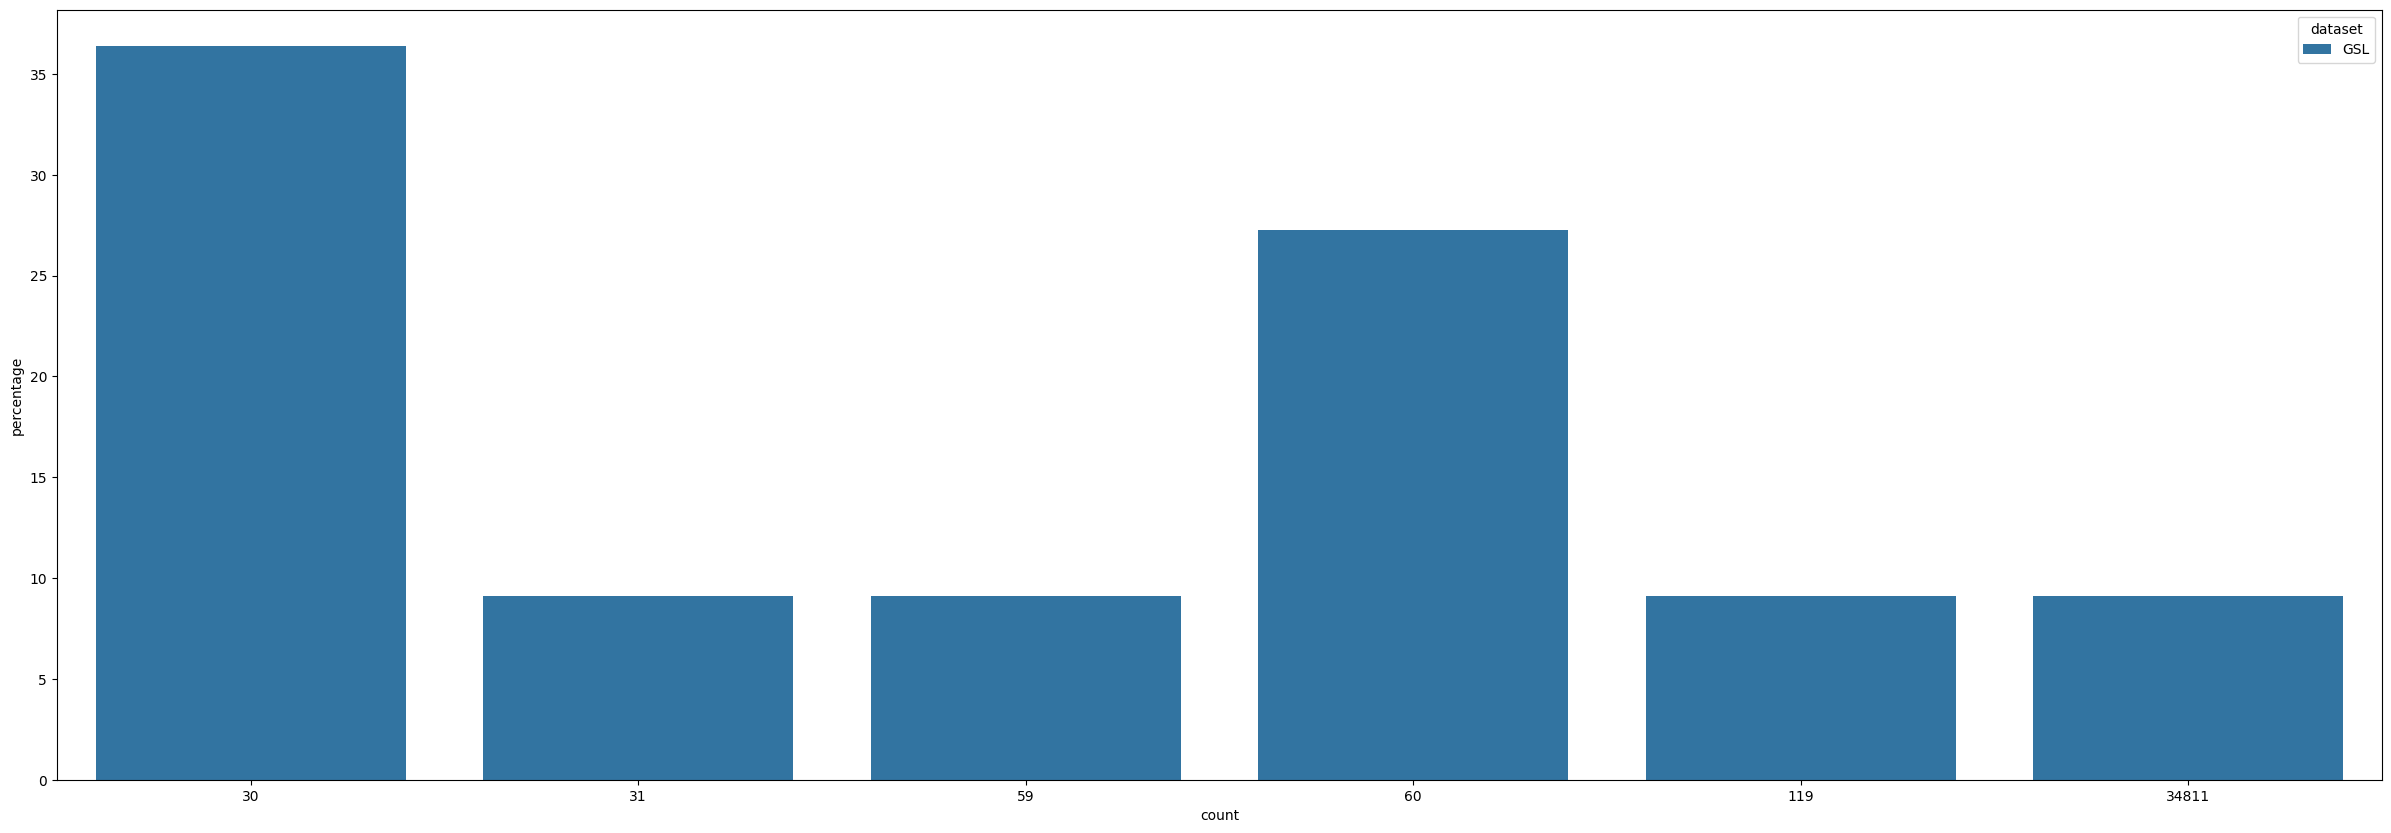

In [12]:
TO_PLOT = 95
token_freqs_top = (
    token_freqs_df[:TO_PLOT].reset_index().rename(columns={"index": "count"})
)
token_freqs_top_melted = token_freqs_top.melt(
    id_vars="count", var_name="dataset", value_name="percentage"
)

plt.figure(figsize=(30, 10))
sns.barplot(x="count", y="percentage", hue="dataset", data=token_freqs_top_melted)
plt.show()